## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Calibration
We can observe that there are 9 corners in a row and 6 corners in a column. I have used glob to iterate over all the camera_cal images to extract the object and image points

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Distortion Correction Example
We use the cameraMatrix and distortionCoeffs to undistort the image.

Text(0.5, 1.0, 'Undistorted Image')

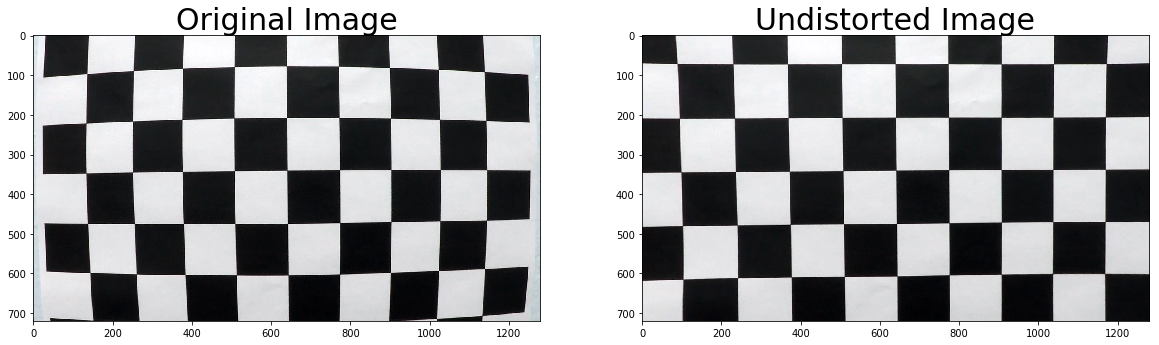

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../camera_cal/calibration1_undistort.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx #用于3D转换至2D的相机matrix
dist_pickle["dist"] = dist #distorion coefficients
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### HLS Color and Gradient Thresholds

In [17]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):

    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). 
    # Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().
    if orient=='x':
        sobel=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)) # (the 1, 0 at the end denotes x direction)
    elif orient=='y':
        sobel=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # Note: It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, 
    # it can be useful in the event that you've written a function to apply a particular threshold, 
    # and you want it to work the same on input images of different scales, like jpg vs. png. 
    # You could just as well choose a different standard range of values, like 0 to 1 etc.
    
    abssobel=np.uint8(255*sobel/np.max(sobel))
    mask=np.zeros_like(abssobel)
    mask[(abssobel>=thresh[0])&(abssobel<=thresh[1])]=1
    return mask

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy=np.sqrt(sobelx**2+sobely**2)
    scale_sobel=np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output=np.zeros_like(scale_sobel)
    binary_output[(scale_sobel<=mag_thresh[1])&(scale_sobel>=mag_thresh[0])]=1
    return binary_output

def dir_thresh(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    theta=np.arctan2(sobelx, sobely)
    binary_output=np.zeros_like(theta)
    binary_output[(theta<=dir_thresh[1])&(theta>=dir_thresh[0])]=1# Remove this line
    return binary_output

# def hls_thresh(img, sthresh=(0, 255), lthresh=(0,255)):
#     hls=cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
#     L=hls[:,:,1]
#     S=hls[:,:,2]
#     lbinary_output=np.zeros_like(L)
#     sbinary_output=np.zeros_like(S)
#     lbinary_output[(L<=lthresh[1]) & (L>lthresh[0])]=1
#     sbinary_output[(S<=sthresh[1]) & (S>sthresh[0])]=1
#     binary_output = np.zeros_like(L)
#     binary_output[(lbinary_output == 1) & (sbinary_output == 1)] = 1
#     return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])  ] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])  ] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
image = mpimg.imread('../test_images/test000031.081.jpg')

# undisort the image 
dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
undist = cv2.undistort(image, mtx, dist, None, mtx)

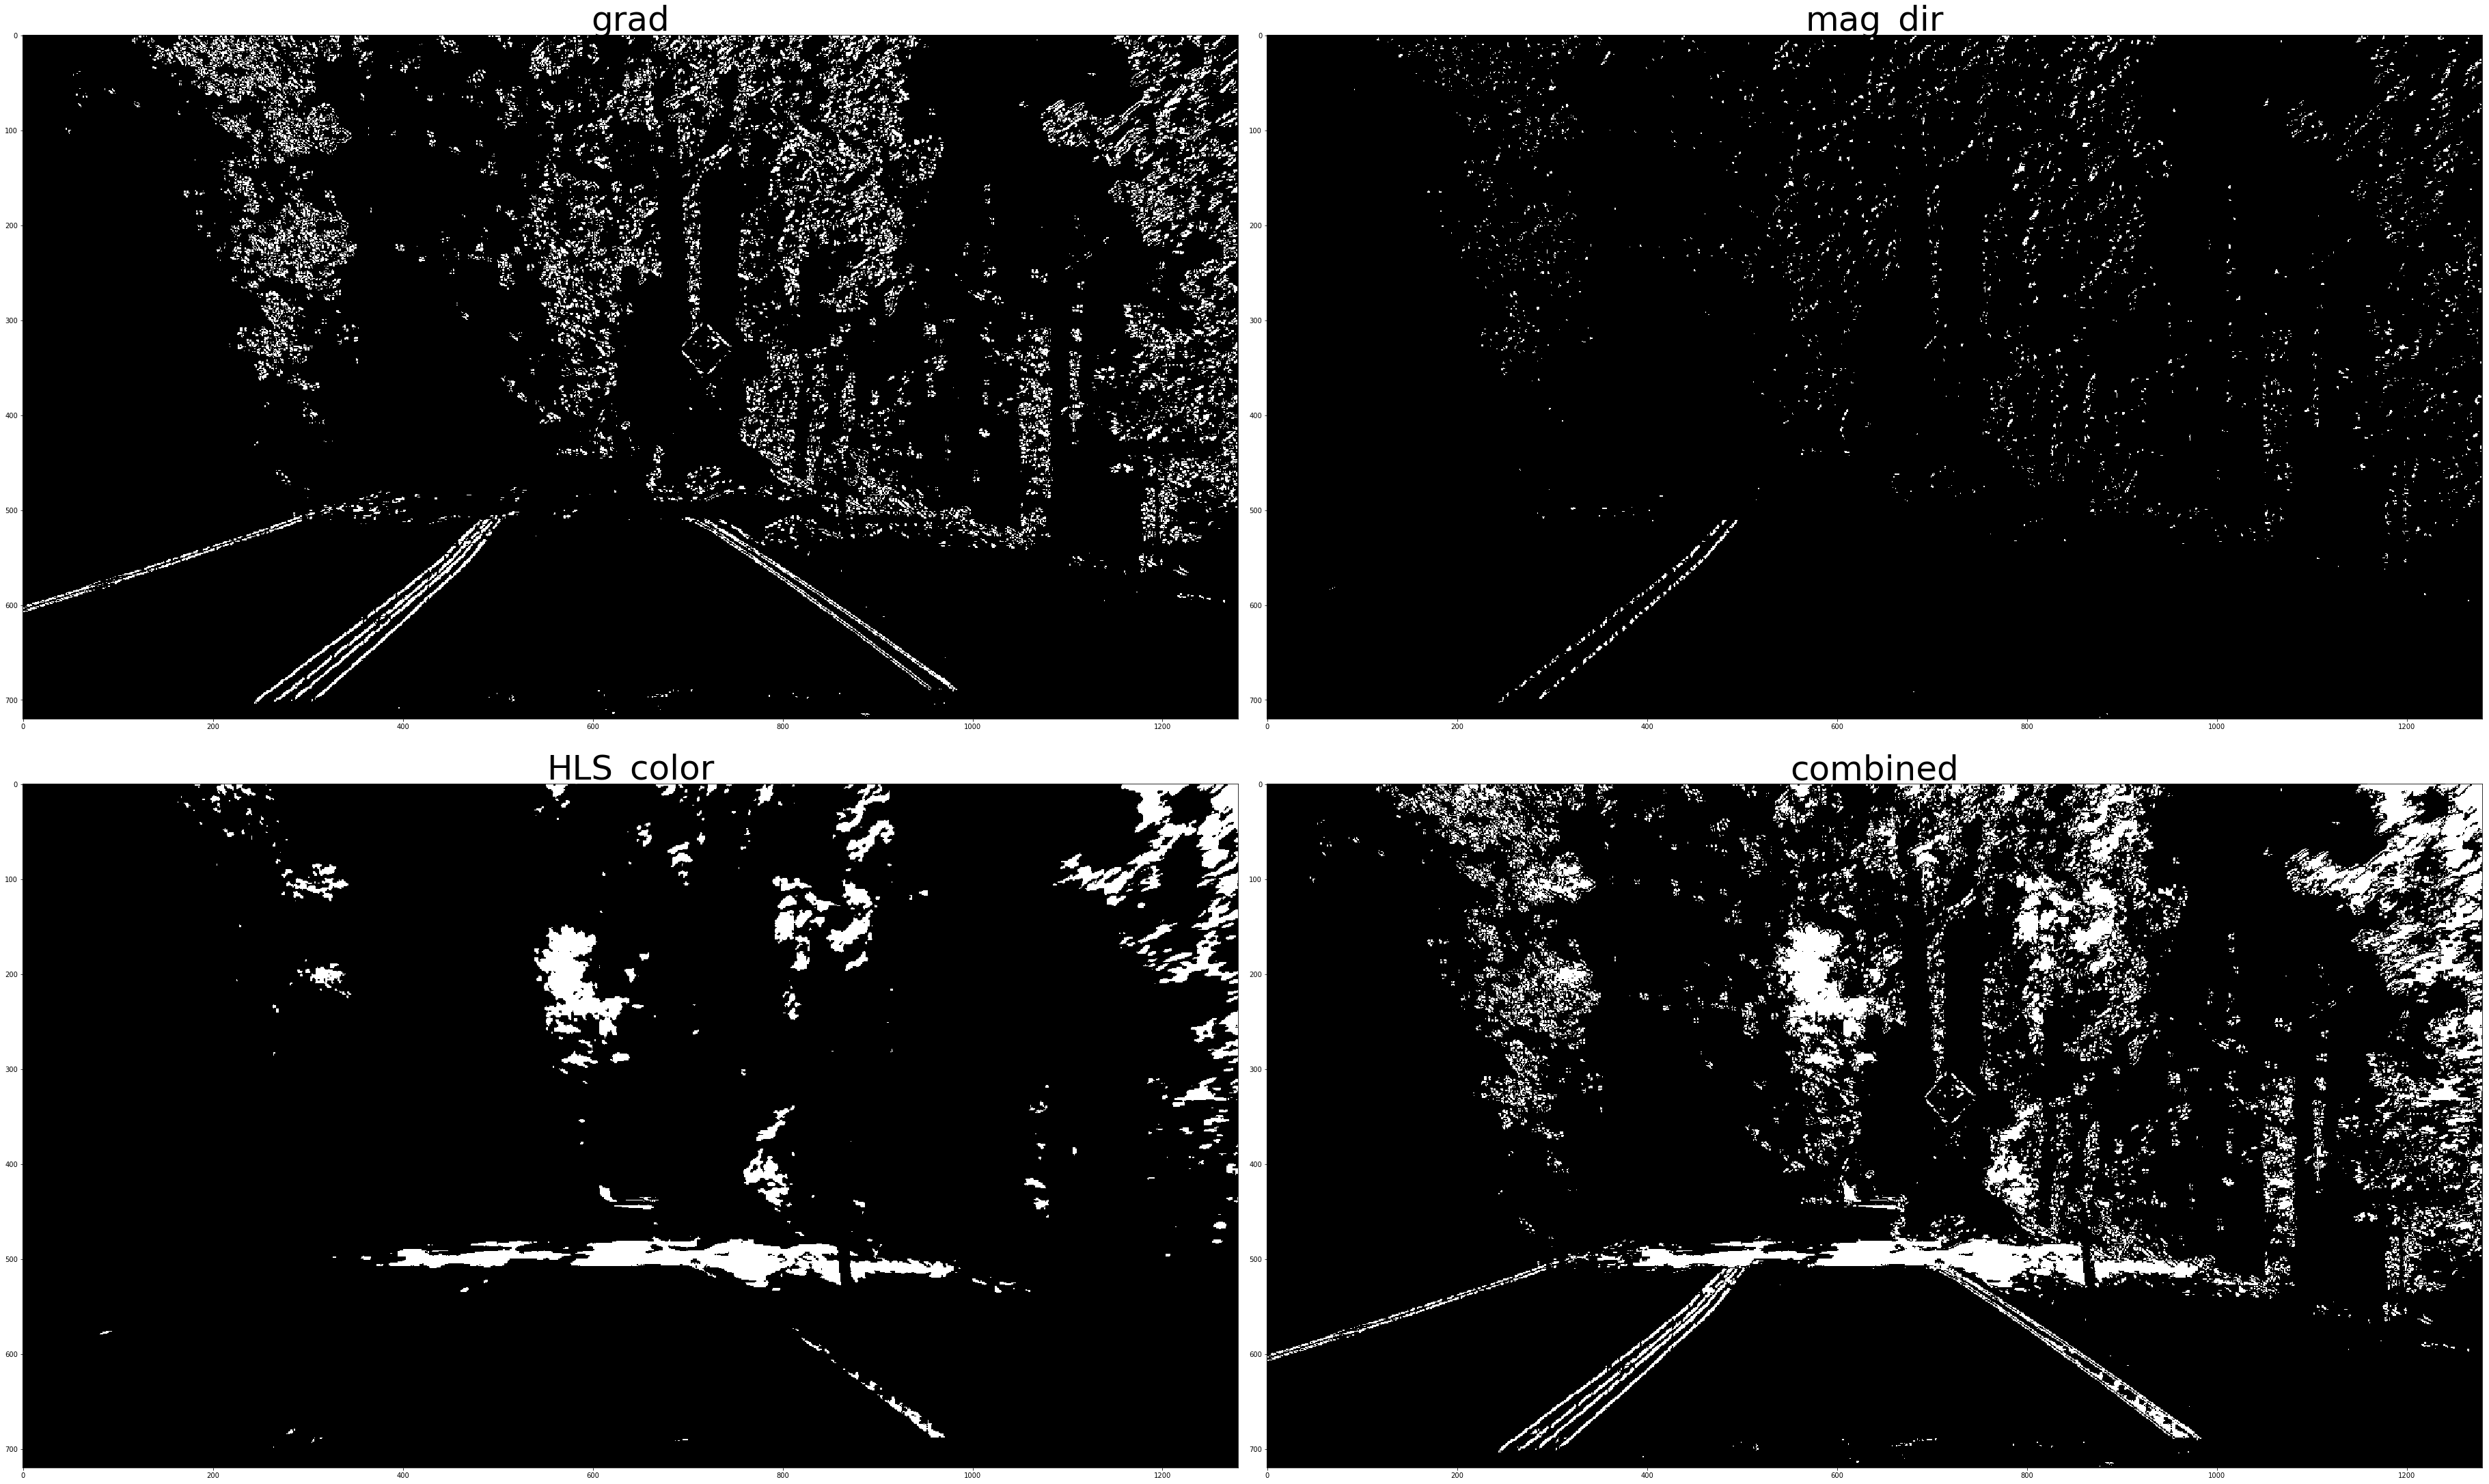

In [11]:
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
grad = np.zeros_like(gradx)
grad[(gradx == 1) & (grady == 1)] = 1

mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(undist, sobel_kernel=ksize, dir_thresh=(0.7, 1.3))
mag_dir = np.zeros_like(mag_binary)
mag_dir[(mag_binary == 1) & (dir_binary == 1)] = 1

color_threshold = color_threshold(undist, sthresh=(100,255), vthresh=(200,255))

combined = np.zeros_like(dir_binary)
combined[(grad == 1) | (mag_dir == 1) | (color_threshold == 1 )] = 1

f, axes = plt.subplots(2, 2,  figsize=(50, 30))
f.tight_layout()
axes[0,0].imshow(grad, cmap='gray')
axes[0,0].set_title('grad', fontsize=50)
axes[0,1].imshow(mag_dir, cmap='gray')
axes[0,1].set_title('mag_dir', fontsize=50)
axes[1,0].imshow(hls_binary, cmap='gray')
axes[1,0].set_title('color_threshold', fontsize=50)
axes[1,1].imshow(combined, cmap='gray')
axes[1,1].set_title('combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Perspective Transform
First choose a region for our task.

In [12]:
# height, width = combined.shape
# mask = np.zeros_like(combined)
# region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
# cv2.fillPoly(mask, [region_of_interest_vertices], 1)
# combined_interest = cv2.bitwise_and(combined, mask)
# plt.imshow(combined_interest, cmap='Greys_r')

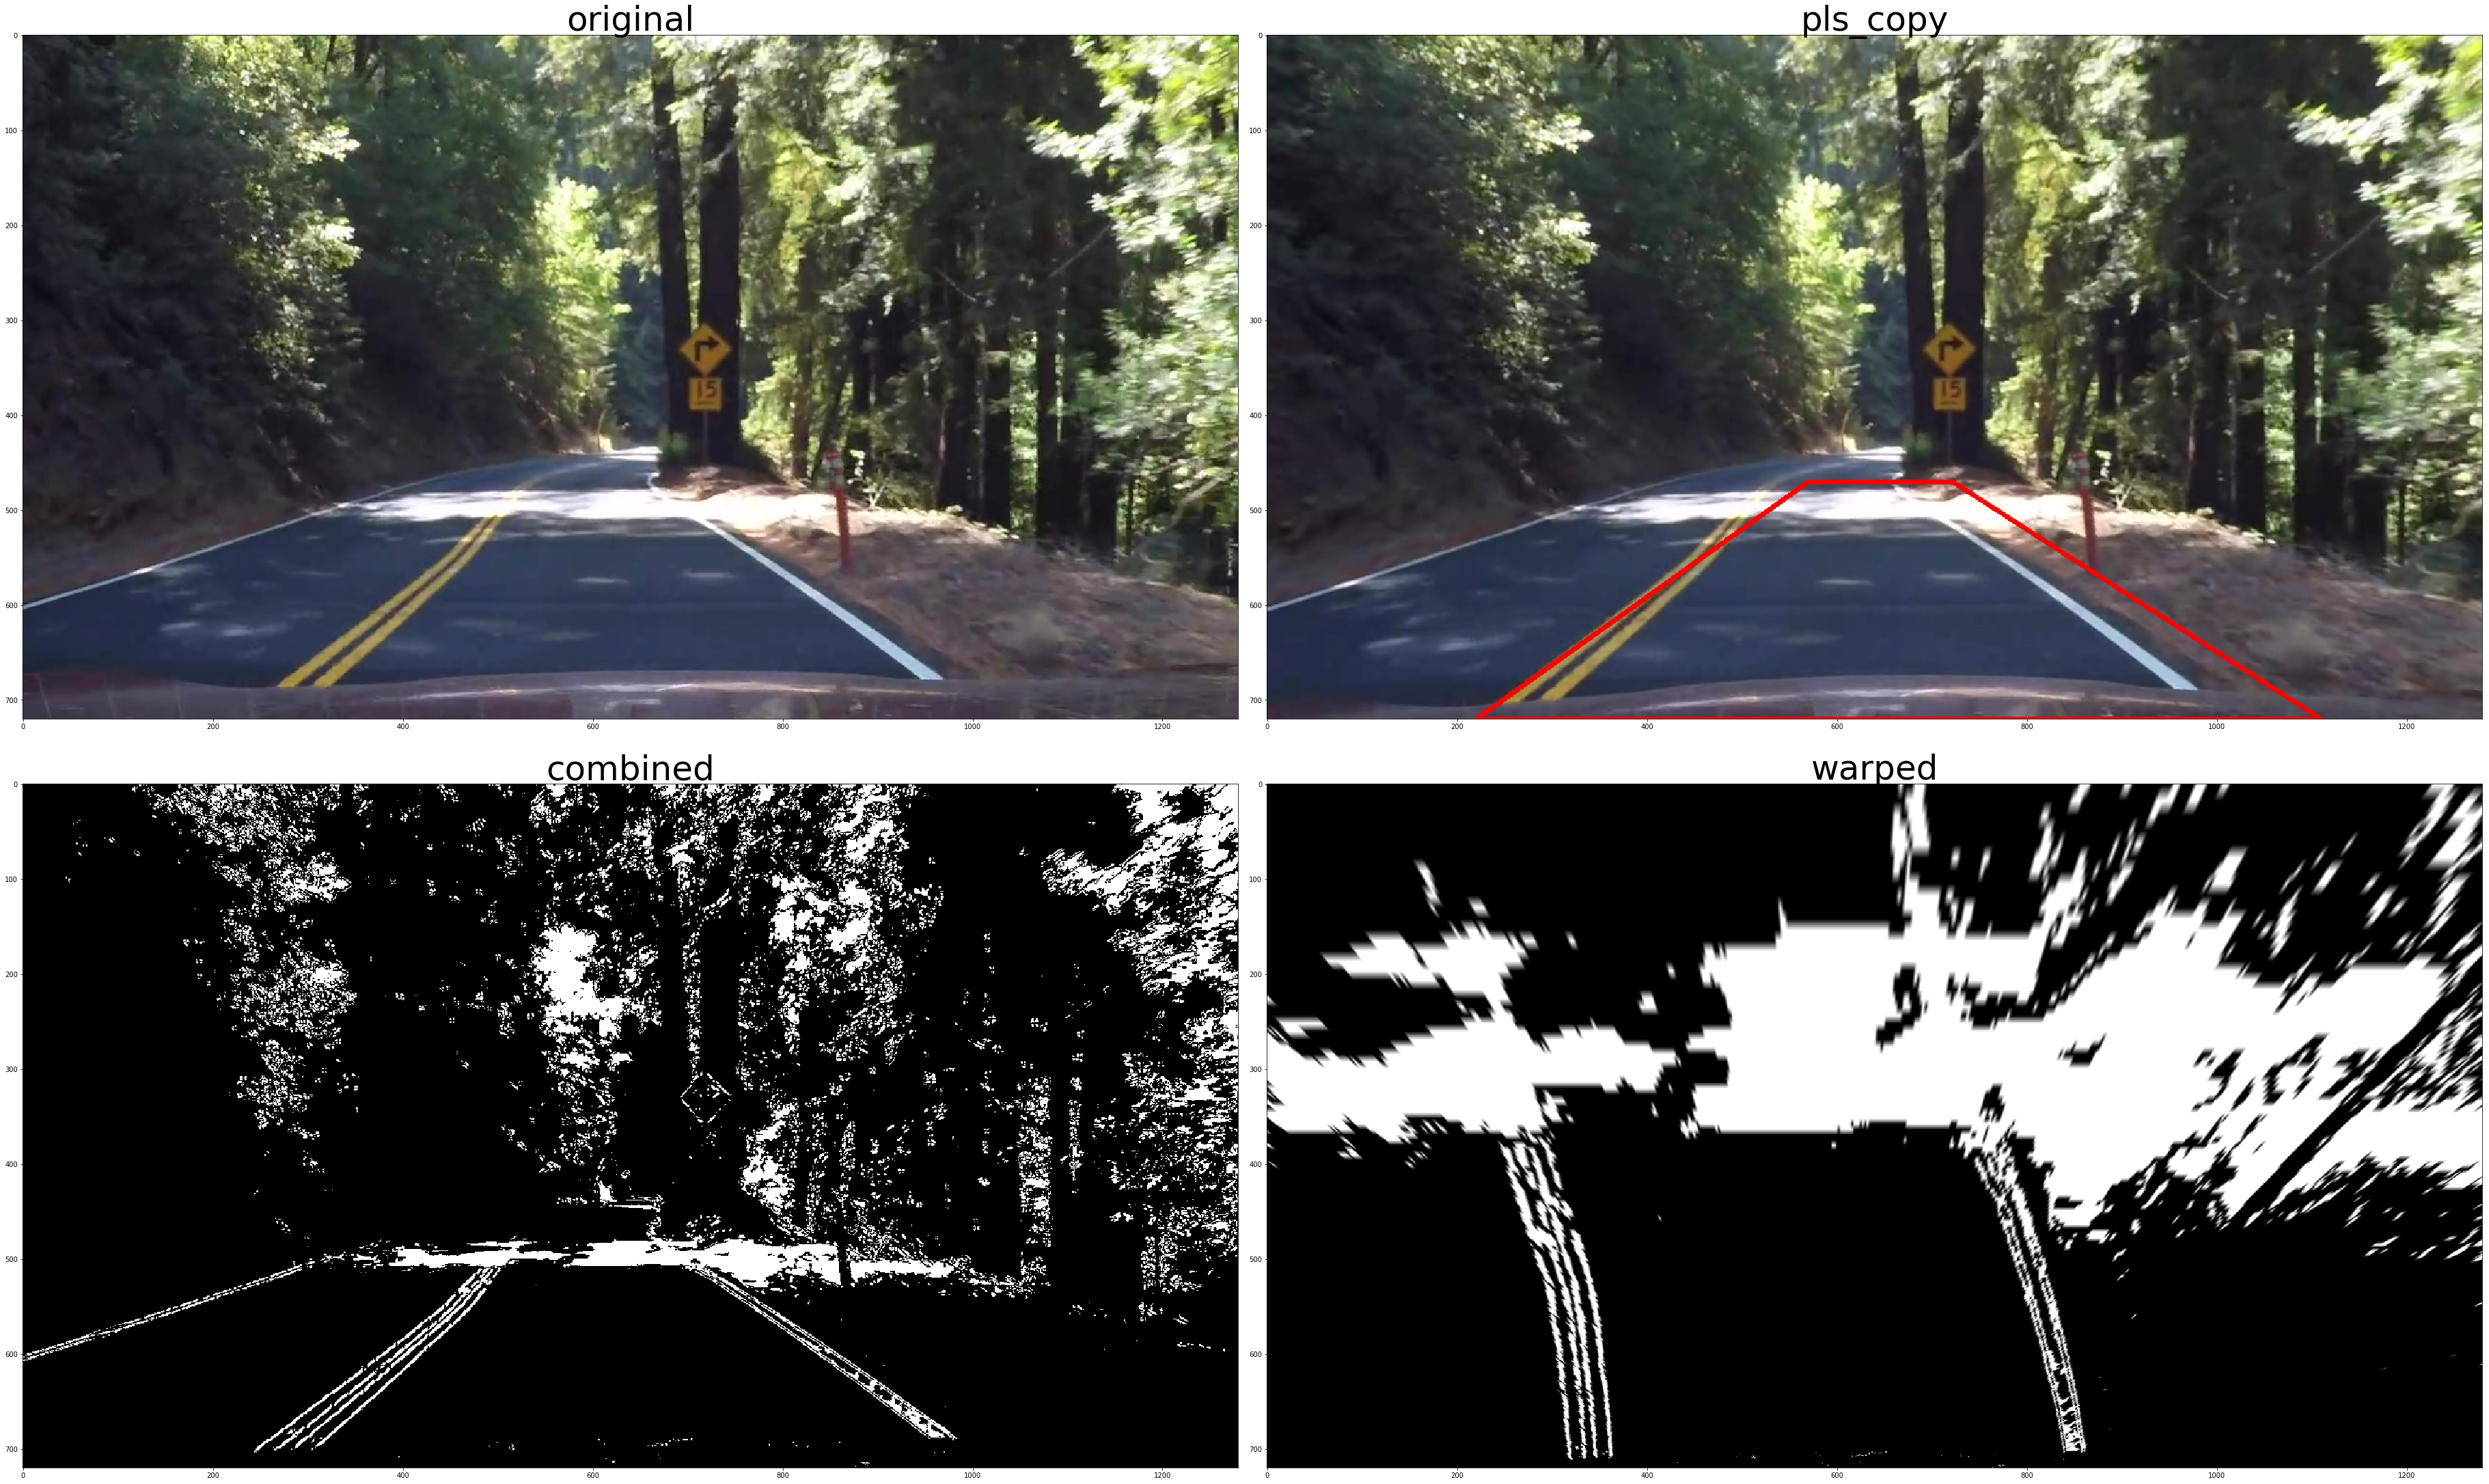

In [13]:
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]
source = np.float32([bottom_left,bottom_right,top_right,top_left])

# pls_copy为转换的区域
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
pls_copy = undist.copy()
cv2.polylines(pls_copy,[pts],True,(255,0,0), thickness=3)

bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]
# Destination points 使直线变为平行
dst = np.float32([bottom_left,bottom_right,top_right,top_left])

def corners_unwarp(img, source, dst):
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    # M_inv 用于之后的计算
    return warped, M, M_inv

warped, perspective_M, perspective_M_inv = corners_unwarp(combined, source, dst)

f, axes = plt.subplots(2, 2,  figsize=(50, 30))
f.tight_layout()
axes[0,0].imshow(image)
axes[0,0].set_title('original', fontsize=50)
axes[0,1].imshow(pls_copy)
axes[0,1].set_title('pls_copy', fontsize=50)
axes[1,0].imshow(combined, cmap='gray')
axes[1,0].set_title('combined', fontsize=50)
axes[1,1].imshow(warped, cmap='gray')
axes[1,1].set_title('warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Identifying the lane pixels
The peaks int the histogram tell us about the likely position of the lanes in the image.

542 828


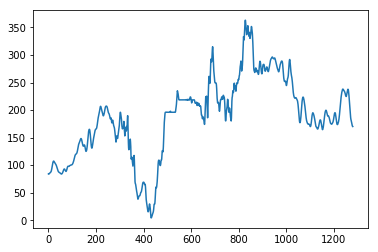

In [14]:
histogram = np.sum(warped, axis=0)
#将warped的所有列相加，得到lane lines的位置

half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])
rightx_base = np.argmax(histogram[half_width:]) + half_width
# np.argmax返回array中最大值的序号

print(leftx_base, rightx_base)
plt.plot(histogram)

## Sliding Window Search

(720, 0)

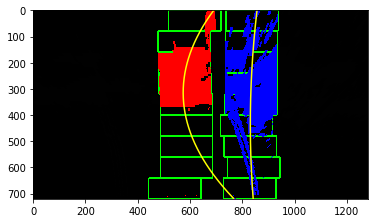

In [15]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# 得到所有 nonzero pixels 的坐标
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- window_width
window_width = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # 确定window的个顶点坐标x与y
    win_y_low = warped.shape[0] - (window+1)*window_height 
    win_y_high = warped.shape[0] - window*window_height 
    win_xleft_low = leftx_current - window_width 
    win_xleft_high = leftx_current + window_width
    win_xright_low = rightx_current - window_width
    win_xright_high = rightx_current + window_width
    # Dcv2.rectangle 输入两个对角点坐标即可画出矩形
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 3) # 3是所画线的宽度
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 3) 
    # 及算nonzero点在window中的数量
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # 找到
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial(二阶多项式) to each
left_fit = np.polyfit(lefty, leftx, 2)  
right_fit = np.polyfit(righty, rightx, 2)
# 注：此曲线将y轴作为横轴， x轴作为竖轴


#Visualization
# Generate x and y values for plotting
plot_point = np.linspace(0, warped.shape[0]-1, warped.shape[0]) # plot_point为0到719的整数，为横轴y上的点
left_fit_line = left_fit[0]*plot_point**2 + left_fit[1]*plot_point + left_fit[2]
right_fit_line = right_fit[0]*plot_point**2 + right_fit[1]*plot_point + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
out_img = np.int_(out_img)
plt.imshow(out_img)
plt.plot(left_fit_line, plot_point, color='yellow')
plt.plot(right_fit_line, plot_point, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Searching around a previously detected line
Since consecutive frames are likely to have lane lines in roughly similar positions, in this section we search around a margin of 50 pixels of the previously detected lane lines.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 0)

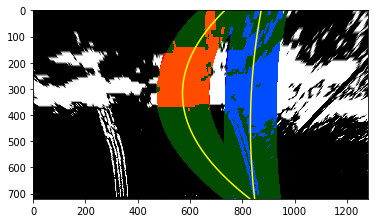

In [16]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "warped")
# It's now much easier to find line pixels!
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
window_width = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - window_width)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + window_width))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - window_width)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + window_width)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# 根据新找的点重新构建新的二阶多项式
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-window_width, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+window_width, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-window_width, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+window_width, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
result = np.int_(cv2.addWeighted(out_img, 1, window_img, 0.3, 0))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [198]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 18050.10 m
Center offset: 0.12 m


### Inverse Transform
* Paint the lane area
* Perform an inverse perspective transform
* Combine the precessed image with the original image.

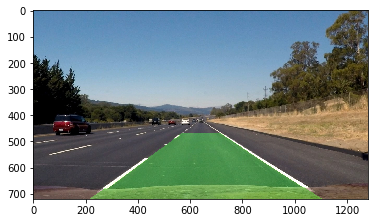

In [200]:
out_img = np.dstack((warped, warped, warped))*255

y_points = np.linspace(0, warped.shape[0]-1, warped.shape[0])

left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

unwarped = np.int_(cv2.warpPerspective(out_img, perspective_M_inv, img_size , flags=cv2.INTER_LINEAR))

result = cv2.addWeighted(image, 1, unwarped, 0.3, 0, dtype=cv2.CV_8U)

plt.imshow(result)